<a href="https://colab.research.google.com/github/saivenkatreddy29/Building-LLM-from-Scratch/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00


In [2]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.5.1+cu121
tiktoken version: 0.8.0


In [3]:
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_out":0.1,
    "qkv_bias":False
}

In [4]:
import torch
from torch import nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_out'])

    #Place holder for transformer block
    self.trf_block = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )
    self.final_norm = DummyLayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias = False)

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    token_embs = self.tok_emb(in_idx)
    pos_embs =self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = token_embs + pos_embs
    x = self.trf_block(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    # A simple place holder

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,normalized_shape,eps = 1e-5):
    super().__init__()
    # parameters that mimic layer norm

  def forward(self,x):
    return x




In [5]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print(f'ouput shape:{logits.shape}')
print(logits)


ouput shape:torch.Size([2, 4, 50257])
tensor([[[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [ 0.0497,  0.3861, -0.3281,  ..., -0.1826,  1.3084,  0.9867],
         [ 0.7005,  1.4747, -0.4149,  ...,  1.7756, -0.2280,  0.5384],
         [ 0.4885,  1.7545, -0.6707,  ...,  1.1501, -0.1143, -0.9368]],

        [[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [-0.5591,  0.5797, -0.1296,  ...,  0.2691,  0.3151,  1.4046],
         [ 0.8524,  1.2833, -0.1786,  ..., -0.1982,  0.1097,  0.2812],
         [-0.0190, -0.8277,  0.2299,  ...,  1.7974, -0.1646, -0.1049]]],
       grad_fn=<UnsafeViewBackward0>)


Normalizing activations with layer normalization

In [7]:
torch.manual_seed(123)
random_tens = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
output = layer(random_tens)
print(output)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
means = output.mean(dim = -1,keepdim = True)
var = output.var(dim = -1,keepdim = True)
print(means)
print(var)
norm_output = (output-means)/torch.sqrt(var)
print(norm_output)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)


In [9]:
mean_norm = norm_output.mean(dim = -1,keepdim = True )
var_norm = norm_output.var(dim = -1,keepdim = True)
torch.set_printoptions(sci_mode = False)
print(mean_norm)
print(var_norm)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim =-1,keepdim = True)
    var = x.var(dim = -1,keepdim = True,unbiased = False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * norm_x + self.shift

In [11]:
ln = LayerNorm(emb_dim = 5)
normal_tens = ln(random_tens)
print(normal_tens.mean(dim = -1,keepdim = True))
print(normal_tens.var(dim = -1,keepdim = True,unbiased = False))

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU implementation

In [12]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    output = 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))* (x + 0.044715*torch.pow(x,3))))
    return output

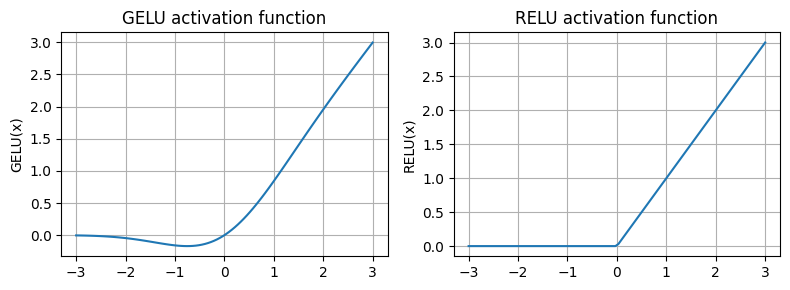

In [13]:
import matplotlib.pyplot as plt
gelu,relu = GELU(),nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu,y_relu = gelu(x),relu(x)
# print(y_gelu.shape)

plt.figure(figsize = (8,3))
for i,(y,label) in enumerate(zip([y_gelu,y_relu],["GELU","RELU"]),1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

Implementing as class

In [14]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'],cfg['emb_dim']),
    )

  def forward(self,x):
    return self.layers(x)

In [15]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [16]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Adding Shortcut Connections

In [43]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcuts = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
    ])

  def forward(self,x):
    for layer in self.layers:
      layer_output = layer(x)
    # layer_
      if self.use_shortcuts and layer_output.shape == x.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

def print_gradients(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  criterion = nn.MSELoss()
  loss = criterion(output,target)
  loss.backward()

  for name,param in model.named_parameters():
    if 'weight' in name:
      print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')


In [44]:
layer_sizes = [3,3,3,3,3,1]

sample_input = torch.tensor([[1.,0.,-1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = False)
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [45]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = True)

print_gradients(model_with_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576
